In [1]:
__author__ = 'aqeel'
#Note Remove This Line to Get the Figure in Seperate Window
%matplotlib inline
from math import pow, sqrt
from random import randint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
np.random.seed(1337)
import pylab
import copy
#All The Environment Code Moved to this file.
from env import *

# Sarsa with Linear Function Aproximation

In [5]:
#+1 at the end of each domain (so in range work properly)
dl = [(1,5),(4,8),(7,11)]
pl = [(1,7),(4,10),(7,13),(10,16),(13,19),(16,22)]
ac = [0,1]
def Active_Features(dfc,pls,acc):
    fs = np.zeros((3,6,2))
    for i,__ in np.ndenumerate(fs):
        if dfc in range(dl[i[0]][0],dl[i[0]][1]) and pls in range(pl[i[1]][0],pl[i[1]][1]) and acc == i[2]:
            #print 'index:{},dealer range:{},{}, Player range:{},{},Action:{}'.\
            #format(i,dl[i[0]][0],dl[i[0]][1],pl[i[1]][0],pl[i[1]][1],i[2])
            fs[i]=1
    return fs

In [6]:
def Get_Value(w,dfc,pls,acc):
    return np.sum(Active_Features(dfc,pls,acc)*w)

In [7]:
def GetPlayerAction(cst,w):
    if np.random.rand() <= 0.05:
        rnd = np.random.randint(2)
        return 0 if rnd == 0 else 1
    else:
        return 0 if Get_Value(w,cst.FirstDealerCard,cst.playersum,0)>Get_Value(w,cst.FirstDealerCard,cst.playersum,1) else 1

In [8]:
def CalculateMSE():
    global Qsa,Values
    total = 0
    for key in values.keys():
        total+= pow(values[key].value-Qsa[key[0]-1,key[1]-1,key[2]],2)
    return sqrt(total)/420

In [16]:
def getQsa(w):
    Qsa = np.zeros((21,10,2))
    for i,__ in np.ndenumerate(Qsa):
        Qsa[i] = Get_Value(w,i[1],i[0],i[2])
    return Qsa

In [15]:
allQsa=[]
step_size=0.01
#for lmbda in np.arange(0,1.1,0.1):
for lmbda in [0]:
#for lmbda in [1]:
    #For Reproducibility 
    np.random.seed(1337)
    w = np.random.normal(size=(3,6,2))
    #Randomly initiated.


    for i in range (0,1000):
        #---Game Started -----#
        Easy21 = State(DrawBlackCard(),DrawBlackCard())
        action = GetPlayerAction(Easy21,w)
        e =0
        while True:
            (oldp,oldd,olda) = (Easy21.playersum,Easy21.FirstDealerCard,action)
            step(Easy21,action)
            action= GetPlayerAction(Easy21,w)
            #Update Qsa
            #Update(oldp-1,oldd-1,olda,Easy21.Reward,Easy21.playersum-1,action,Easy21.terminated)
            if not Easy21.terminated:
                qnext = Get_Value(w,Easy21.FirstDealerCard,Easy21.playersum,action)
            else:
                qnext=0
            delta = Easy21.Reward + qnext-Get_Value(w,oldd,oldp,olda)
            e = lmbda*e+Active_Features(oldd,oldp,olda)
            w += step_size * e * delta
            if Easy21.terminated:
                break
        Qsa = getQsa(w)
        allQsa.append((i,CalculateMSE()))
    #---Game Ended---#
    
    #Calculate for different Lambda
    #allQsa.append((lmbda,CalculateMSE())) 
print 'Finished'

Finished


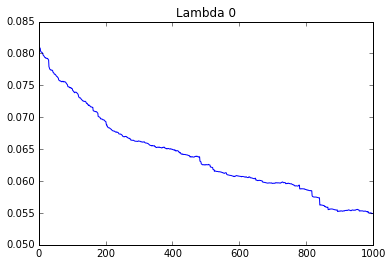

In [17]:
allinfo = np.array(allQsa)
plt.plot(allinfo[:,0],allinfo[:,1])
plt.title('Lambda 0')
plt.show()

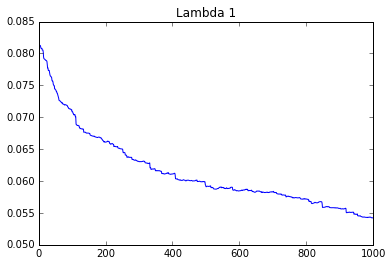

In [14]:
allinfo = np.array(allQsa)
plt.plot(allinfo[:,0],allinfo[:,1])
plt.title('Lambda 1')
plt.show()

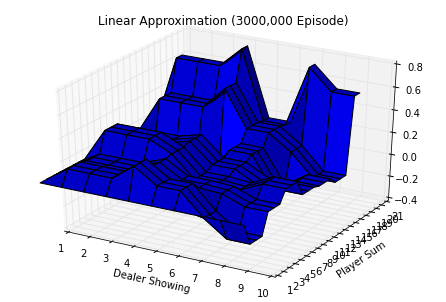

In [67]:
# plot the value function
x = range(0, 10)  # dealer
y = range(0, 21)  # player
X, Y = np.meshgrid(x, y)
Z = np.array([[0. for i in range(len(x))] for j in range(len(y))])
for i in x:
    for j in y:
        Z[j][i] = max(Qsa[(j, i,0)],Qsa[j, i,1])
            
fig = pylab.figure()
ax = Axes3D(fig)
pylab.title("Linear Approximation (3000,000 Episode)")
ax.set_xlabel("Dealer Showing")
pylab.xlim([1, 10])
pylab.xticks(range(1, 11))
ax.set_ylabel("Player Sum")
pylab.ylim([1, 21])
pylab.yticks(range(1, 22))
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
pylab.show()

No matter how much I increased the Episode the look stayed the same. I believe this mode doesn't suite this problem at all. maybe it'll work for continue problems.

# Code Below Only to Get Q*

In [2]:
class Values:
    
    value=0
    occurence=0
    # You should add here Gt and each step you calculate Gt
    def UpdateValues(self,value):
        self.occurence += 1
        self.value += (float(1)/float(self.occurence))*(value-self.value)

values = {}

def AddValue(playersum , dealercard,value,action):
    #if playersum<1:
    #    return
    if (playersum,dealercard,action) in values.keys():
        (values[(playersum,dealercard,action)]).UpdateValues(value)
    else:
        tmp = Values()
        tmp.UpdateValues(value)
        values[(playersum,dealercard,action)] = tmp
def ConsumeEpisode(episode):
    for i in range (len(episode.playersum)):
        AddValue(episode.playersum[i],episode.DelaerFirstCard,episode.Gt[i],episode.action[i])

class Episode:
    #Created it this way to make it more general
    def __init__(self):
        self.reward=[]
        self.Gt=[]
        self.DelaerFirstCard=0
        self.playersum=[]
        self.action=[]
    
    
    def Finalize(self):
        '''
        This Function Calculate Gt for all states
        '''
        self.Gt=np.zeros(len(self.reward))
        #The last element Gt = immediate reward
        self.Gt[len(self.reward)-1]=self.reward[len(self.reward)-1]
        #Each Gt = Immediate reward + gamma*nextreward
        for i in range(len(self.reward)-2,-1,-1):
            self.Gt[i]= self.reward[i]+gamma*self.Gt[i+1]


In [3]:
gamma = 1
exploration=5
def GetPlayerAction():
    #Exploration rate 50%
    if randint(1,10)<5:
        if (Easy21.playersum,Easy21.FirstDealerCard,0) in values.keys() and  (Easy21.playersum,Easy21.FirstDealerCard,1) in values.keys():
            #print 'this happen'
            return 0 if values[(Easy21.playersum,Easy21.FirstDealerCard,0)].value>values[(Easy21.playersum,Easy21.FirstDealerCard,1)] else 1
    #if (Easy21.playersum>17):
    #    return 1
    #if (Easy21.playersum>17):
    #    return 1
    return (1 if randint(1,10)>5 else 0)
values={}
print len(values.keys())
for i in range (0,1000000):
    #---Game Started -----#
    Easy21 = State(DrawBlackCard(),DrawBlackCard())
    episode = Episode()
    episode.action.append(0)
    episode.DelaerFirstCard = Easy21.FirstDealerCard
    episode.reward.append(0)
    episode.playersum.append(Easy21.playersum)
    #---Inititation values ----#
    action = GetPlayerAction()
    while True:
        step(Easy21,action)
        episode.playersum.append(Easy21.playersum)
        #print action
        episode.action.append(action)
        episode.reward.append(Easy21.Reward)
        #AddValue(Easy21.playersum,Easy21.FirstDealerCard,Easy21.Reward)
        if Easy21.terminated:
            #print 'test'
            #print Easy21.Reward
            episode.Finalize()
            ConsumeEpisode(episode)
            break
        if action==1:
            break
        else:
            action=GetPlayerAction()
    #---Game Ended---#

0


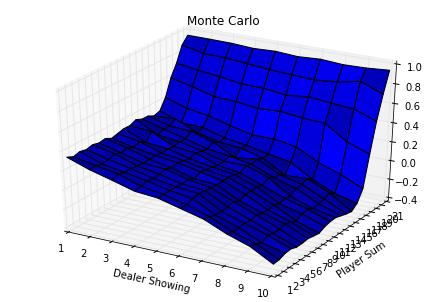

In [4]:
# plot the value function
x = range(1, 11)  # dealer
y = range(1, 22)  # player
X, Y = np.meshgrid(x, y)
Z = np.array([[0. for i in range(len(x))] for j in range(len(y))])
for i in x:
    for j in y:
        v0 = (j, i,0) in values.keys()
        v1 =  (j, i,1) in values.keys()
        if  v0 and v1:
            Z[j - 1][i - 1] = max(values[(j, i,0)].value,values[(j, i,1)].value)
        elif v0:
            Z[j - 1][i - 1] = values[(j, i,0)].value
        elif v1:
            Z[j - 1][i - 1] = values[(j, i,1)].value
            
fig = pylab.figure()
ax = Axes3D(fig)
pylab.title("Monte Carlo")
ax.set_xlabel("Dealer Showing")
pylab.xlim([1, 10])
pylab.xticks(range(1, 11))
ax.set_ylabel("Player Sum")
pylab.ylim([1, 21])
pylab.yticks(range(1, 22))
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
pylab.show()